<a href="https://colab.research.google.com/github/ffelipeaom/Data_Immersion4-HouseSearch-SP/blob/master/FelipeAugusto_final_house_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
!pip install geopandas
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import numpy as np
from folium import Choropleth, Marker
from folium.plugins import MarkerCluster
from sklearn.metrics import mean_absolute_error, r2_score
from shapely.geometry import Polygon
from shapely.geometry import Point

pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

url = "https://gist.githubusercontent.com/tgcsantos/3bdb29eba6ce391e90df2b72205ba891/raw/22fa920e80c9fa209a9fccc8b52d74cc95d1599b/dados_imoveis.csv"
df = pd.read_csv(url)

ibge_url = "https://gist.githubusercontent.com/tgcsantos/85f8c7b0a2edbc3e27fcad619b37d886/raw/a4954781e6bca9cb804062a3eea0b3b84679daf4/Basico_SP1.csv"
sp_ibge = pd.read_csv(ibge_url, encoding='ISO-8859-1', sep=';', thousands='.', decimal=',')
sp_ibge.dropna(how='all', axis=1, inplace=True)
sp_ibge.head()

df_adresses = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/enderecos.csv")
sp_adresses = df_adresses.query("sigla_uf == 'SP'")

ibge_gpkg = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/alura imersao 4/35SEE250GC_SIR.gpkg")
sp_gpkg = ibge_gpkg[ibge_gpkg.NM_MUNICIP == "SÃO PAULO"]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Exploring the data frames

In [87]:
df

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000
...,...,...,...,...,...,...,...,...
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$ 2.300.000
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000
10006,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,R$ 2.200\n /Mês


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB


In [89]:
sp_ibge

,Cod_setor,Cod_Grandes Regiï¿½es,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,...,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,355030801000001,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.01,2.32,2091.32,8532451.78,2164.55,8673276.78,1227.41,4285771.99,1713.75,5152087.86
1,355030801000002,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,2.98,2.09,1650.09,3983441.31,1717.44,4030519.99,1045.78,2572133.32,1468.08,2991546.94
2,355030801000003,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.31,3.08,1280.43,5474593.06,2349.53,7553913.02,902.97,2735492.52,1786.79,3837674.74
3,355030801000004,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.16,2.26,1119.59,3572955.10,1859.13,4567289.50,869.09,2122409.02,1567.41,2735383.24
4,355030801000005,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.14,2.35,1416.90,2240207.58,1581.66,2240109.39,917.71,1570047.75,1356.35,1725877.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18358,355030896000243,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.50,2.61,772.09,168751.10,814.52,143188.21,467.46,191332.48,699.95,123399.08
18359,355030896000244,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.87,2.49,692.50,239941.27,812.93,182516.20,439.33,194034.99,702.10,124952.38
18360,355030896000245,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.90,2.54,630.06,329705.22,843.31,260395.90,347.60,228162.66,767.50,181129.99
18361,355030896000246,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,4.29,4.21,597.37,349101.00,908.00,244391.67,397.76,436942.16,854.20,550319.43


In [90]:
sp_ibge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18363 entries, 0 to 18362
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Cod_setor              18363 non-null  int64  
 1   Cod_Grandes Regiï¿½es  18363 non-null  int64  
 2   Nome_Grande_Regiao     18363 non-null  object 
 3   Cod_UF                 18363 non-null  int64  
 4   Nome_da_UF             18363 non-null  object 
 5   Cod_meso               18363 non-null  int64  
 6   Nome_da_meso           18363 non-null  object 
 7   Cod_micro              18363 non-null  int64  
 8   Nome_da_micro          18363 non-null  object 
 9   Cod_RM                 18363 non-null  int64  
 10  Nome_da_RM             18363 non-null  object 
 11  Cod_municipio          18363 non-null  int64  
 12  Nome_do_municipio      18363 non-null  object 
 13  Cod_distrito           18363 non-null  int64  
 14  Nome_do_distrito       18363 non-null  object 
 15  Co

In [91]:
sp_gpkg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18953 entries, 42322 to 62384
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          18953 non-null  float64 
 1   CD_GEOCODI  18953 non-null  object  
 2   TIPO        18953 non-null  object  
 3   CD_GEOCODS  18953 non-null  object  
 4   NM_SUBDIST  0 non-null      object  
 5   CD_GEOCODD  18953 non-null  object  
 6   NM_DISTRIT  18953 non-null  object  
 7   CD_GEOCODM  18953 non-null  object  
 8   NM_MUNICIP  18953 non-null  object  
 9   NM_MICRO    18953 non-null  object  
 10  NM_MESO     18953 non-null  object  
 11  CD_GEOCODB  0 non-null      object  
 12  NM_BAIRRO   0 non-null      object  
 13  ID1         18953 non-null  int64   
 14  geometry    18953 non-null  geometry
dtypes: float64(1), geometry(1), int64(1), object(12)
memory usage: 2.3+ MB


In [92]:
df_adresses

,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude
0,Rua,Armando Silveira,Rua Armando Silveira,NaN,Divisa,Santana do Livramento,RS,97573200.00,-30.88,-55.55
1,Rua,João Antônio Vasconcelos,Rua João Antônio Vasconcelos - até 627/628,627,Amizade,Araçatuba,SP,16074320.00,-21.19,-50.45
2,Rua,Prefeito Agenor Barcelos Feio,Rua Prefeito Agenor Barcelos Feio,NaN,Registro,Santana do Livramento,RS,97571090.00,-30.86,-55.56
3,Rua,Sebastião Gomes,Rua Sebastião Gomes - até 59/60,59,Registro,Santana do Livramento,RS,97571374.00,-30.86,-55.55
4,Rua,Marquês do Alegrete,Rua Marquês do Alegrete,NaN,Parque das Águas,Santana do Livramento,RS,97571500.00,-30.86,-55.55
...,...,...,...,...,...,...,...,...,...,...
1113881,Quadra,4 Conjunto 7,Quadra 4 Conjunto 7,NaN,Setor Habitacional Vicente Pires - Trecho 3,Brasília,DF,72001381.00,-15.70,-47.87
1113882,Rodovia,Mario Tonolli,Rodovia Mario Tonolli,NaN,Morro Alto,Itupeva,SP,13297002.00,-23.19,-47.08
1113883,Avenida,das Torres,Avenida das Torres - de 6318 ao fim - lado par,6318,Lago Azul,Manaus,AM,69018156.00,-2.99,-59.99
1113884,Rua,Tiradentes,Rua Tiradentes - de 181 a 369 - lado ímpar,181,Vila Queiroz,Artur Nogueira,SP,13163000.00,-22.58,-47.17


In [93]:
df_adresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113886 entries, 0 to 1113885
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   tipo_logr        1113559 non-null  object 
 1   logr_nome        1113566 non-null  object 
 2   logr_compl       1113567 non-null  object 
 3   numero           28810 non-null    object 
 4   bairro           1113546 non-null  object 
 5   nome_localidade  1093788 non-null  object 
 6   sigla_uf         1093788 non-null  object 
 7   cep              1093788 non-null  float64
 8   latitude         1090660 non-null  float64
 9   longitude        1090660 non-null  float64
dtypes: float64(3), object(7)
memory usage: 85.0+ MB


# Preparing the "dados_imoveis" data frame
First I want to prepare the data: convert and clean unreadable data, make some easier to read and analyze, then relate some variables to find significant data.

The "Valor" (value) index contains important data for what we want to do: the price of each house. Some of this pricing is rent per day/month/year, however. And since its an object-type with more than just numbers, we will have to work it before converting into float.

In [94]:
#fixing the values and cleaning the Valor column
df_fixed_valor = df
df_fixed_valor[["Valor_Reais", "Anuncio"]] = df["Valor"].str.split(expand = True).drop(columns=0) #splitting the Valor index
df_fixed_valor = df_fixed_valor[df_fixed_valor["Anuncio"].isnull()].drop(columns=["Valor", "Anuncio"]) #removes lines that correspond to rent price, then cleans the df
df_fixed_valor["Valor_Reais"] = df_fixed_valor["Valor_Reais"].str.replace(".","").astype(float) #cleans the values of Valor_Reais before converting them into float
df_fixed_valor.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_Reais
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00


Below, I scale the price to millions reais for better readability. Then, I calculate the square meter price for each entry, which might give us some insight later.

In [95]:
#create a scale in millions of Valor
df_fixed_valor["Valor_Mi"] = df_fixed_valor["Valor_Reais"]/1000000
df_fixed_valor.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_Reais,Valor_Mi
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7.00
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,3.70
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,0.38
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00,0.69
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,0.54


In [96]:
#finding the square meter price for each entry
df_fixed_valor["Valor_m2"] = df_fixed_valor["Valor_Reais"]/df_fixed_valor["Metragem"]
df_fixed_valor.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_Reais,Valor_Mi,Valor_m2
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7.00,7000.00
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,3.70,7459.68
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,0.38,3040.00
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00,0.69,2209.68
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,0.54,5400.00


# Preparing the "sp_address" data frame
The data frame "enderecos" have data about the houses' geographical location, which I will be using to merge with the df_fixed_valor data frame, adding some more data to it and also helping in plotting some maps later.

In [97]:
sp_adresses.head()

,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude
1,Rua,João Antônio Vasconcelos,Rua João Antônio Vasconcelos - até 627/628,627,Amizade,Araçatuba,SP,16074320.00,-21.19,-50.45
413269,Rua,A,Rua A,NaN,Jardim Glória,Americana,SP,13468220.00,-22.76,-47.34
413270,Rua,A,Rua A,NaN,Jardim São Roque,Americana,SP,13469414.00,-22.74,-47.35
413271,Rua,A,Rua A,NaN,Iate Clube de Campinas,Americana,SP,13475620.00,-22.74,-47.33
413272,Rua,João Bandini,Rua João Bandini,NaN,Jardim Miriam,Americana,SP,13469072.00,-22.74,-47.35


In [98]:
#setting up an index to merge on sp_address data frame
sp_adresses["address"] = sp_adresses["tipo_logr"] + " " + sp_adresses["logr_nome"]
sp_adresses["address"] = sp_adresses["address"].str.lower().str.strip()
sp_adresses.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude,address
1,Rua,João Antônio Vasconcelos,Rua João Antônio Vasconcelos - até 627/628,627,Amizade,Araçatuba,SP,16074320.00,-21.19,-50.45,rua joão antônio vasconcelos
413269,Rua,A,Rua A,NaN,Jardim Glória,Americana,SP,13468220.00,-22.76,-47.34,rua a
413270,Rua,A,Rua A,NaN,Jardim São Roque,Americana,SP,13469414.00,-22.74,-47.35,rua a
413271,Rua,A,Rua A,NaN,Iate Clube de Campinas,Americana,SP,13475620.00,-22.74,-47.33,rua a
413272,Rua,João Bandini,Rua João Bandini,NaN,Jardim Miriam,Americana,SP,13469072.00,-22.74,-47.35,rua joão bandini


In [99]:
#setting up an index to merge on df_fixed_valor data frame
df_fixed_valor["clean_address"] = df_fixed_valor["Rua"].str.extract(r'(^[\w ]+)')
df_fixed_valor["clean_address"] = df_fixed_valor["clean_address"].str.lower().str.strip()
df_fixed_valor.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_Reais,Valor_Mi,Valor_m2,clean_address
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7.00,7000.00,avenida itacira
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,3.70,7459.68,rua aurelia perez alvarez
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,0.38,3040.00,rua alba valdez
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00,0.69,2209.68,NaN
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,0.54,5400.00,rua tobias barreto


# Merging data frames

In [100]:
#df_fixed_valor and sp_address
dados_geo = pd.merge(left = df_fixed_valor, right = sp_adresses[["address", "cep", "latitude", "longitude"]], 
                     how = "left", left_on = "clean_address", right_on = "address").drop_duplicates(subset=df_fixed_valor.columns).query("cep > 0")
dados_geo = dados_geo.drop(columns = "address")
dados_geo.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_Reais,Valor_Mi,Valor_m2,clean_address,cep,latitude,longitude
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7.00,7000.00,avenida itacira,11443160.00,-23.98,-46.20
5,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,3.70,7459.68,rua aurelia perez alvarez,4642020.00,-23.64,-46.69
6,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,0.38,3040.00,rua alba valdez,4845200.00,-23.75,-46.70
7,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00,0.69,2209.68,NaN,18125000.00,-23.53,-47.26
26,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,0.54,5400.00,rua tobias barreto,13474663.00,-22.70,-47.29


In [101]:
sp_gpkg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18953 entries, 42322 to 62384
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          18953 non-null  float64 
 1   CD_GEOCODI  18953 non-null  object  
 2   TIPO        18953 non-null  object  
 3   CD_GEOCODS  18953 non-null  object  
 4   NM_SUBDIST  0 non-null      object  
 5   CD_GEOCODD  18953 non-null  object  
 6   NM_DISTRIT  18953 non-null  object  
 7   CD_GEOCODM  18953 non-null  object  
 8   NM_MUNICIP  18953 non-null  object  
 9   NM_MICRO    18953 non-null  object  
 10  NM_MESO     18953 non-null  object  
 11  CD_GEOCODB  0 non-null      object  
 12  NM_BAIRRO   0 non-null      object  
 13  ID1         18953 non-null  int64   
 14  geometry    18953 non-null  geometry
dtypes: float64(1), geometry(1), int64(1), object(12)
memory usage: 2.3+ MB


In [102]:
dados_geo["Point"] = ""
for i in dados_geo.index:
    dados_geo["Point"][i] = Point(dados_geo["longitude"][i], dados_geo["latitude"][i])

dados_geo['setor_censo'] = dados_geo["Point"].map(
    lambda x: sp_gpkg.loc[sp_gpkg.contains(x), 'CD_GEOCODI'].values
).str[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [103]:
dados_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8520 entries, 0 to 89977
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rua            5639 non-null   object 
 1   Bairro         8512 non-null   object 
 2   Cidade         8520 non-null   object 
 3   Metragem       8520 non-null   int64  
 4   Quartos        8520 non-null   int64  
 5   Banheiros      8520 non-null   int64  
 6   Vagas          8520 non-null   int64  
 7   Valor_Reais    8520 non-null   float64
 8   Valor_Mi       8520 non-null   float64
 9   Valor_m2       8520 non-null   float64
 10  clean_address  5639 non-null   object 
 11  cep            8520 non-null   float64
 12  latitude       8520 non-null   float64
 13  longitude      8520 non-null   float64
 14  Point          8520 non-null   object 
 15  setor_censo    3897 non-null   object 
dtypes: float64(6), int64(4), object(6)
memory usage: 1.4+ MB


In [104]:
#dados_geo and sp_ibge
dados_geo["setor_censo"] = dados_geo["setor_censo"].astype(float)
df_merged = pd.merge(left = dados_geo, right = sp_ibge, how = "left", left_on = "setor_censo", right_on = "Cod_setor")

In [105]:
df_merged = df_merged[['Rua', 'Bairro', 'Cidade', 'Metragem', 'Quartos', 'Banheiros', 'Vagas',
       'Valor_Reais', 'Valor_Mi', 'Valor_m2', 'latitude', 'longitude', 'Situacao_setor', 'V001',
       'V002', 'V003', 'V004', 'V005', 'V006', 'V007', 'V008', 'V009', 'V010',
       'V011', 'V012']].dropna()       

In [106]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3890 entries, 1 to 8519
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rua             3890 non-null   object 
 1   Bairro          3890 non-null   object 
 2   Cidade          3890 non-null   object 
 3   Metragem        3890 non-null   int64  
 4   Quartos         3890 non-null   int64  
 5   Banheiros       3890 non-null   int64  
 6   Vagas           3890 non-null   int64  
 7   Valor_Reais     3890 non-null   float64
 8   Valor_Mi        3890 non-null   float64
 9   Valor_m2        3890 non-null   float64
 10  latitude        3890 non-null   float64
 11  longitude       3890 non-null   float64
 12  Situacao_setor  3890 non-null   float64
 13  V001            3890 non-null   float64
 14  V002            3890 non-null   float64
 15  V003            3890 non-null   float64
 16  V004            3890 non-null   float64
 17  V005            3890 non-null   f

# Plotting
Plotting will help us to find some relations and outliers.

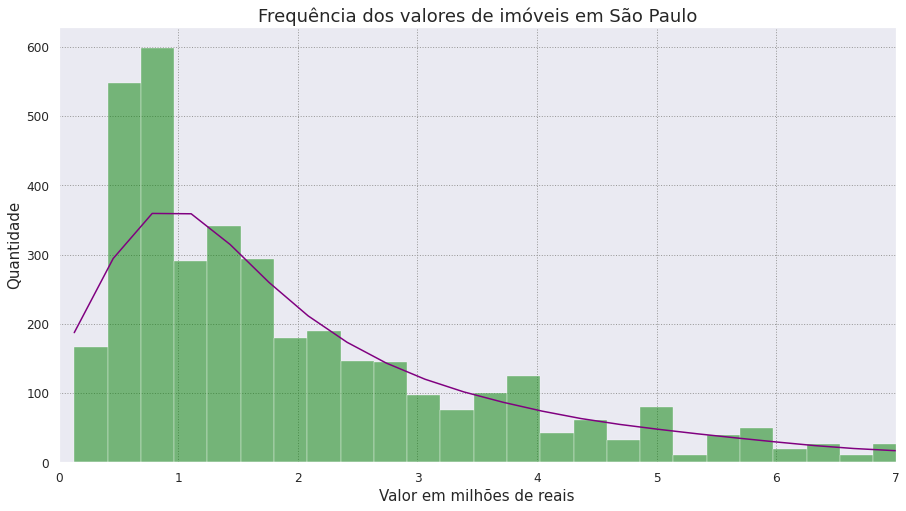

In [107]:
#histogram: price frequency in são paulo city
plt.figure(figsize=(15, 8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("notebook", font_scale=1.1)
hist_merged = sns.histplot(data = df_merged, x = "Valor_Mi", kde = True, color = "green")
hist_merged.lines[0].set_color('purple')
hist_merged.set_title("Frequência dos valores de imóveis em São Paulo", fontsize = 18)
plt.xlabel("Valor em milhões de reais", fontsize = 15)
plt.ylabel("Quantidade", fontsize = 15)
plt.xlim(0,7)
plt.show()

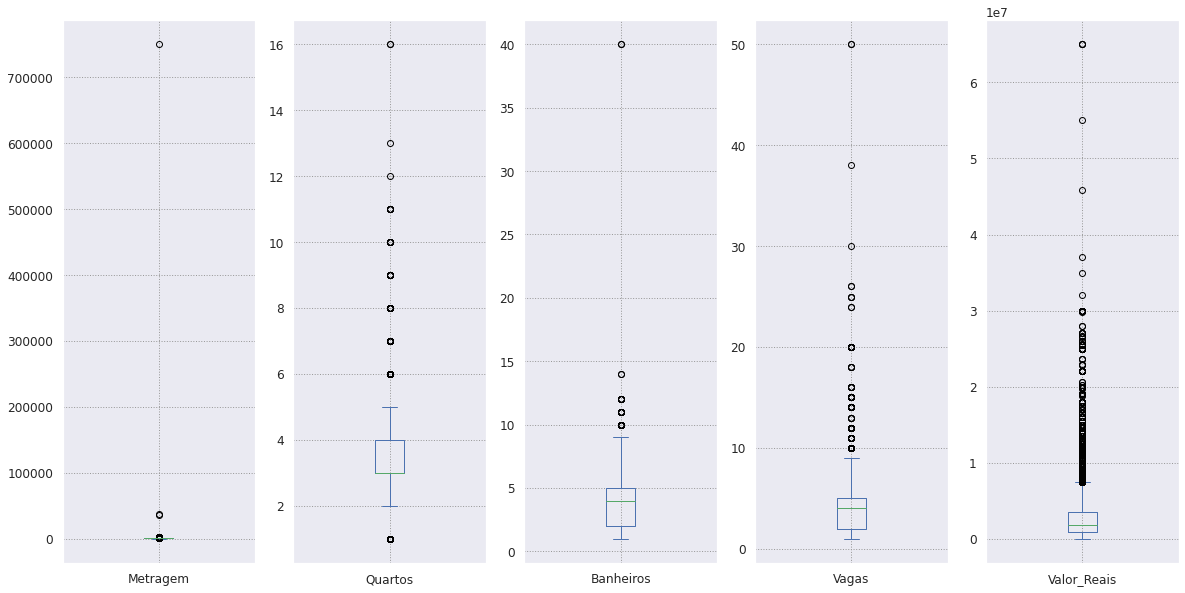

In [108]:
#boxplot of footage, number of rooms, bathrooms, parking spaces, and price in reais
f, axes = plt.subplots(nrows=1, ncols=5)
count=0
for n in df_merged.iloc[:,3:8]:
  df_fixed_valor[[n]].plot.box(ax=axes[count])
  count+=1 

We can see outliers defining a lot of these plots, and that is possobly not only a visual matter. Some of these outliers may be getting in the way of understanding the data better and, therefore, making better decisions.

# Dealing with outliers
I will be using the Interquartile Range (IQR) method for dealing with outliers. Such method measures statistical dispersion by the median of the lower and upper half of the data, enhancing the accuracy of data by dropping lower contribution and outliers.

In [109]:
#Interquartile Range method
df_IQR = df_merged
sns.set(rc = {'figure.figsize':(20,10)})
for n in df_IQR.iloc[:,3:8]:
  nseries = df_IQR[[n]]
  nQ1 = nseries.quantile(0.25)
  nQ3 = nseries.quantile(0.75)
  nIQR = nQ3 - nQ1
  df_IQR = df_IQR[~((nseries < (nQ1 - 1.5 * nIQR)) | (nseries > (nQ3 + 1.5 * nIQR))).any(axis=1)]

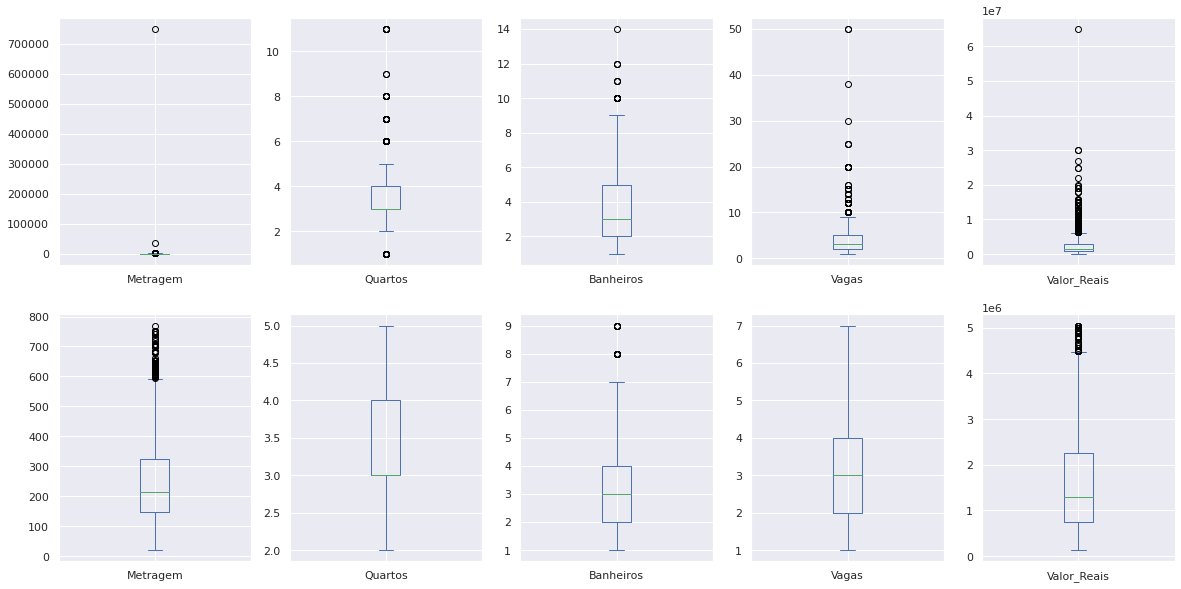

In [110]:
#plotting the difference
f, axes = plt.subplots(nrows=2, ncols=5)
count_IQR = 0
for n in df_IQR.iloc[:,3:8]:
  df_merged[[n]].plot.box(ax=axes[0, count_IQR], subplots = True)
  df_IQR[[n]].plot.box(ax=axes[1,count_IQR], subplots = True)
  count_IQR+=1

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b991e8a50>],
      dtype=object)

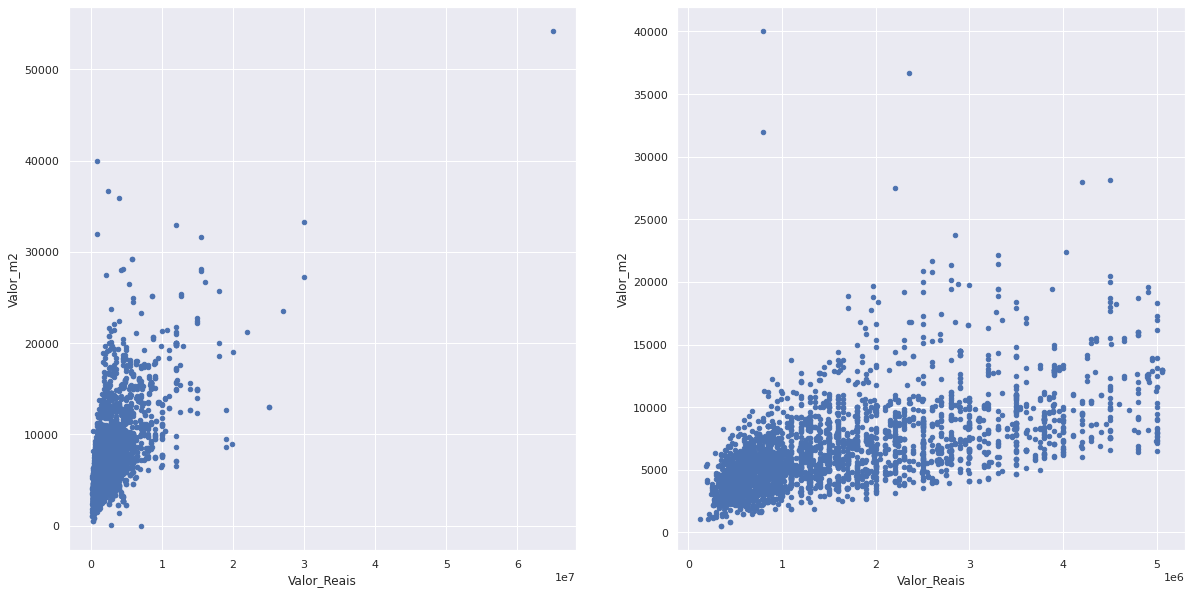

In [111]:
#plt.figure(figsize=(10, 10))
#sns.set(rc = {'figure.figsize':(10,10)})
f, axes = plt.subplots(nrows=1, ncols=2)
df_merged.plot.scatter(x="Valor_Reais", y="Valor_m2", subplots = True, ax=axes[0])
df_IQR.plot.scatter(x="Valor_Reais", y="Valor_m2", subplots = True, ax=axes[1])

# Predictions
I will be using three prediction models: Linear Regression, Polynominal Regression and Support Vector Machine.

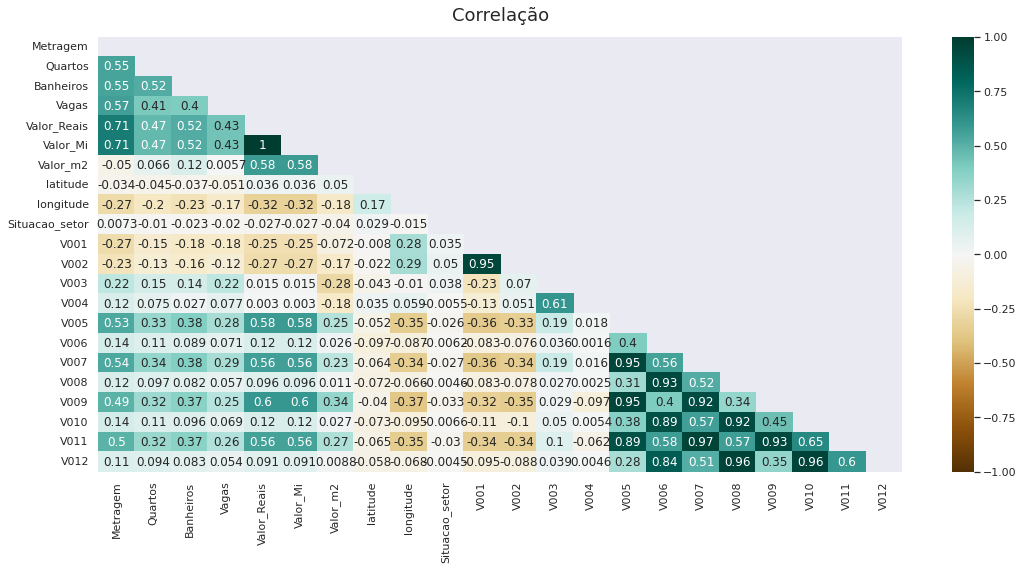

In [112]:
#some correlation to help us to pick interesting variables for predictions
plt.figure(figsize=(18, 8))
mask = np.triu(np.ones_like(df_IQR.corr(), dtype=bool))
heatmap = sns.heatmap(df_IQR.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlação', fontdict={'fontsize':18}, pad=16);

In [113]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm

Text(0.5, 0, 'Valor real')

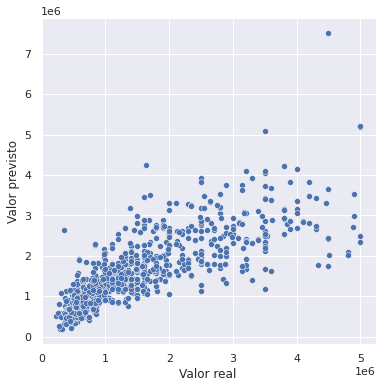

In [114]:
#linear regression
X = df_IQR[['Metragem', 'Quartos', 'Banheiros', 'Vagas','V005','V007', 'V009', 'V011']]
Y = df_IQR["Valor_Reais"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 11)
clf = LinearRegression()

clf.fit(X_train, Y_train)
Y_predict_test = clf.predict(X_test)
Y_predict_train = clf.predict(X_train)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=Y_test, y=Y_predict_test)
plt.ylabel("Valor previsto")
plt.xlabel("Valor real")

In [115]:
mae_test = mean_absolute_error(Y_test, Y_predict_test)
mae_test

471984.9471161497

In [116]:
r2_test = r2_score(Y_test, Y_predict_test)
r2_test

0.6117194999065804

Text(0.5, 0, 'Valor real')

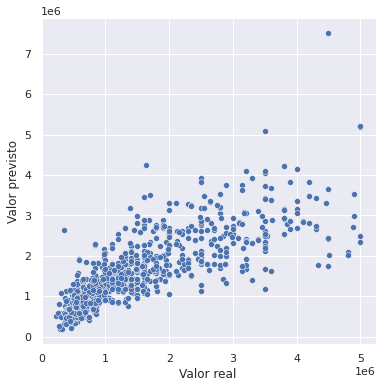

In [117]:
#polynominal regressions
poly = PolynomialFeatures(degree = 3)
poly.fit_transform(X_train)
Y_predict_train = clf.predict(X_train)
Y_predict_test = clf.predict(X_test)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=Y_test, y=Y_predict_test)
plt.ylabel("Valor previsto")
plt.xlabel("Valor real")

In [118]:
mae_test = mean_absolute_error(Y_test, Y_predict_test)
mae_test

471984.9471161497

In [119]:
r2_test = r2_score(Y_test, Y_predict_test)
r2_test

0.6117194999065804

In [120]:
#support vector machines
clf = svm.SVR()
clf.fit(X_train, Y_train)
Y_predict_train = clf.predict(X_train)
Y_predict_test = clf.predict(X_test)

In [121]:
mae_test = mean_absolute_error(Y_test, Y_predict_test)
mae_test

809285.3213721348

In [122]:
r2_test = r2_score(Y_test, Y_predict_test)
r2_test

-0.052887831627989934

Text(0.5, 0, 'Valor real')

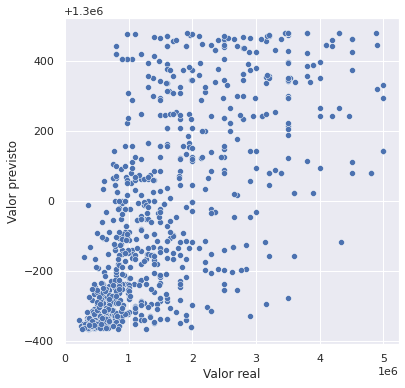

In [123]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=Y_test, y=Y_predict_test)
plt.ylabel("Valor previsto")
plt.xlabel("Valor real")

These predictions are subpar. The SVM model predicted negative values for price. A Mean Absolute Error of nearing half a million for Linear and Polynomial Regression tell us there are still problems with modelling the data, probably pointing to a not-enough-sized sample.
But a R-squared of 0.611 on the best predictions is at least average. By doing some correlations, and plotting them, might allow us to find interesting information and insights.

# Finding some District data


In [124]:
df_district = df_fixed_valor.groupby("Bairro").sum()
df_district.reset_index(inplace = True)
df_district.head()

,Bairro,Metragem,Quartos,Banheiros,Vagas,Valor_Reais,Valor_Mi,Valor_m2
0,Aclimação,19447,258,240,230,139292801.00,139.29,604837.39
1,Alto da Boa Vista,3351,33,41,37,19130000.00,19.13,46796.55
2,Alto da Lapa,23940,252,308,320,166653500.00,166.65,608538.25
3,Alto da Mooca,5401,66,52,73,23683400.00,23.68,113834.80
4,Alto de Pinheiros,158616,1453,1782,1827,1764815915.00,1764.82,4158622.61


In [125]:
df_district["District_m2"] = df_district["Valor_Reais"]/df_district["Metragem"]
df_district.head()

,Bairro,Metragem,Quartos,Banheiros,Vagas,Valor_Reais,Valor_Mi,Valor_m2,District_m2
0,Aclimação,19447,258,240,230,139292801.00,139.29,604837.39,7162.69
1,Alto da Boa Vista,3351,33,41,37,19130000.00,19.13,46796.55,5708.74
2,Alto da Lapa,23940,252,308,320,166653500.00,166.65,608538.25,6961.30
3,Alto da Mooca,5401,66,52,73,23683400.00,23.68,113834.80,4385.00
4,Alto de Pinheiros,158616,1453,1782,1827,1764815915.00,1764.82,4158622.61,11126.34


Text(0.5, 0, 'Reais/m²')

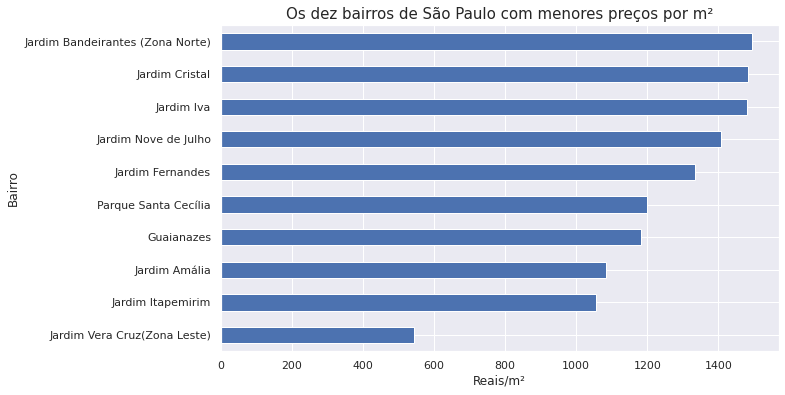

In [126]:
#top_districts = df_district["Bairro"].value_counts()[:10].index
plt.figure(figsize=(10, 6))
district_footage = df_IQR.groupby("Bairro")["Valor_m2"].mean()
hist_valor_m2 = district_footage.sort_values().head(10).plot(kind="barh")
hist_valor_m2.set_title("Os dez bairros de São Paulo com menores preços por m²", fontsize = 15)
hist_valor_m2.set_ylabel("Bairro")
hist_valor_m2.set_xlabel("Reais/m²")

In [127]:
district_ibge = sp_ibge#pd.read_csv(ibge_url, sep = ";", encoding="utf-8", decimal=',')
#district_ibge.dropna(axis=1)
district_ibge.rename(columns = {"Nome_do_distrito":"Bairro"},inplace = True)
district_ibge["Bairro"].unique()

array(['ï¿½GUA RASA', 'ALTO DE PINHEIROS', 'ANHANGUERA', 'ARICANDUVA',
       'ARTUR ALVIM', 'BARRA FUNDA', 'BELA VISTA', 'BELï¿½M',
       'BOM RETIRO', 'BRï¿½S', 'BRASILï¿½NDIA', 'BUTANTï¿½',
       'CACHOEIRINHA', 'CAMBUCI', 'CAMPO BELO', 'CAMPO GRANDE',
       'CAMPO LIMPO', 'CANGAIBA', 'CAPï¿½O REDONDO', 'CARRï¿½O',
       'CASA VERDE', 'CIDADE ADEMAR', 'CIDADE DUTRA', 'CIDADE LIDER',
       'CIDADE TIRADENTES', 'CONSOLAï¿½ï¿½O', 'CURSINO',
       'ERMELINO MATARAZZO', 'FREGUESIA DO ï¿½', 'GRAJAï¿½', 'GUAIANASES',
       'MOEMA', 'IGUATEMI', 'IPIRANGA', 'ITAIM BIBI', 'ITAIM PAULISTA',
       'ITAQUERA', 'JABAQUARA', 'JAï¿½ANï¿½', 'JAGUARA', 'JAGUARï¿½',
       'JARAGUï¿½', 'JARDIM ï¿½NGELA', 'JARDIM HELENA', 'JARDIM PAULISTA',
       'JARDIM Sï¿½O LUï¿½S', 'JOSï¿½ BONIFï¿½CIO', 'LAPA', 'LIBERDADE',
       'LIMï¿½O', 'MANDAQUI', 'MARSILAC', 'MOOCA', 'MORUMBI',
       'PARELHEIROS', 'PARI', 'PARQUE DO CARMO', 'PEDREIRA', 'PENHA',
       'PERDIZES', 'PERUS', 'PINHEIROS', 'PIRITUBA', 

district_ibge = district_ibge.replace({"Bairro" : {'BEL�M' : 'BELÉM',
                      'BRASIL�NDIA' :	'BRASILÂNDIA',
                      'BR�S' : 'BRÁS',
                      'BUTANT�' :	'BUTANTÃ',
                      'CAP�O REDONDO' : 'CAPÃO REDONDO',
                      'CARR�O' : 'CARRÃO',
                      'CONSOLA��O' :	'CONSOLAÇÃO',
                      'FREGUESIA DO �' : 'FREGUESIA DO Ó',
                      'GRAJA�' : 'GRAJAÚ',
                      'JAGUAR�' : 'JAGUARÉ',
                      'JARAGU�' : 'JARAGUÁ',
                      'JARDIM S�O LU�S' : 'JARDIM SÃO LUÍS',
                      'JARDIM �NGELA' : 'JARDIM ÂNGELA',
                      'JA�AN�' : 'JAÇANÃ',
                      'JOS� BONIF�CIO' : 'JOSÉ BONIFÁCIO',
                      'LIM�O' : 'LIMÃO',
                      'REP�BLICA' : 'REPÚBLICA',
                      'SACOM�' : 'SACOMÃ',
                      'SANTA CEC�LIA' : 'SANTA CECÍLIA',
                      'SA�DE' : 'SAÚDE',
                      'S�' : 'SÉ',
                      'S�O DOMINGOS' : 'VILA SÃO DOMINGOS',
                      'S�O LUCAS' : 'SÃO LUCAS',
                      'S�O MATEUS' : 'SÃO MATEUS',
                      'S�O MIGUEL' : 'SÃO MIGUEL',
                      'S�O RAFAEL' : 'SÃO RAFAEL',
                      'TATUAP�' : 'TATUAPÉ',
                      'TREMEMB�' : 'TREMEMBÉ',
                      'VILA CURU��' : 'VILA CURUÇÁ',
                      'VILA JACU�' : 'VILA JACUÍ',
                      'VILA S�NIA' : 'VILA SÔNIA',
                      '�GUA RASA' : 'ÁGUA RASA'}})

In [128]:
district_ibge = district_ibge.replace({"Bairro" : {'BELï¿½M' : 'BELÉM',
                      'BRASILï¿½NDIA' :	'BRASILÂNDIA',
                      'BRï¿½S' : 'BRÁS',
                      'BUTANTï¿½' :	'BUTANTÃ',
                      'CAPï¿½O REDONDO' : 'CAPÃO REDONDO',
                      'CARRï¿½O' : 'CARRÃO',
                      'CONSOLAï¿½ï¿½O' :	'CONSOLAÇÃO',
                      'FREGUESIA DO ï¿½' : 'FREGUESIA DO Ó',
                      'GRAJAï¿½' : 'GRAJAÚ',
                      'JAGUARï¿½' : 'JAGUARÉ',
                      'JARAGUï¿½' : 'JARAGUÁ',
                      'JARDIM Sï¿½O LUï¿½S' : 'JARDIM SÃO LUÍS',
                      'JARDIM ï¿½NGELA' : 'JARDIM ÂNGELA',
                      'JAï¿½ANï¿½' : 'JAÇANÃ',
                      'JOSï¿½ BONIFï¿½CIO' : 'JOSÉ BONIFÁCIO',
                      'LIMï¿½O' : 'LIMÃO',
                      'REPï¿½BLICA' : 'REPÚBLICA',
                      'SACOMï¿½' : 'SACOMÃ',
                      'SANTA CECï¿½LIA' : 'SANTA CECÍLIA',
                      'SAï¿½DE' : 'SAÚDE',
                      'Sï¿½' : 'SÉ',
                      'Sï¿½O DOMINGOS' : 'VILA SÃO DOMINGOS',
                      'Sï¿½O LUCAS' : 'SÃO LUCAS',
                      'Sï¿½O MATEUS' : 'SÃO MATEUS',
                      'Sï¿½O MIGUEL' : 'SÃO MIGUEL',
                      'Sï¿½O RAFAEL' : 'SÃO RAFAEL',
                      'TATUAPï¿½' : 'TATUAPÉ',
                      'TREMEMBï¿½' : 'TREMEMBÉ',
                      'VILA CURUï¿½ï¿½' : 'VILA CURUÇÁ',
                      'VILA JACUï¿½' : 'VILA JACUÍ',
                      'VILA Sï¿½NIA' : 'VILA SÔNIA',
                      'ï¿½GUA RASA' : 'ÁGUA RASA'}})

In [129]:
district_ibge["Bairro"].unique()

array(['ÁGUA RASA', 'ALTO DE PINHEIROS', 'ANHANGUERA', 'ARICANDUVA',
       'ARTUR ALVIM', 'BARRA FUNDA', 'BELA VISTA', 'BELÉM', 'BOM RETIRO',
       'BRÁS', 'BRASILÂNDIA', 'BUTANTÃ', 'CACHOEIRINHA', 'CAMBUCI',
       'CAMPO BELO', 'CAMPO GRANDE', 'CAMPO LIMPO', 'CANGAIBA',
       'CAPÃO REDONDO', 'CARRÃO', 'CASA VERDE', 'CIDADE ADEMAR',
       'CIDADE DUTRA', 'CIDADE LIDER', 'CIDADE TIRADENTES', 'CONSOLAÇÃO',
       'CURSINO', 'ERMELINO MATARAZZO', 'FREGUESIA DO Ó', 'GRAJAÚ',
       'GUAIANASES', 'MOEMA', 'IGUATEMI', 'IPIRANGA', 'ITAIM BIBI',
       'ITAIM PAULISTA', 'ITAQUERA', 'JABAQUARA', 'JAÇANÃ', 'JAGUARA',
       'JAGUARÉ', 'JARAGUÁ', 'JARDIM ÂNGELA', 'JARDIM HELENA',
       'JARDIM PAULISTA', 'JARDIM SÃO LUÍS', 'JOSÉ BONIFÁCIO', 'LAPA',
       'LIBERDADE', 'LIMÃO', 'MANDAQUI', 'MARSILAC', 'MOOCA', 'MORUMBI',
       'PARELHEIROS', 'PARI', 'PARQUE DO CARMO', 'PEDREIRA', 'PENHA',
       'PERDIZES', 'PERUS', 'PINHEIROS', 'PIRITUBA', 'PONTE RASA',
       'RAPOSO TAVARES', 'REPÚBLICA

In [130]:
df_district["Bairro"] = df_district["Bairro"].str.upper()
district_ibge["Bairro"] = district_ibge["Bairro"].str.upper()
merged_district = df_district.merge(district_ibge, on ='Bairro', how = 'left')
merged_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11693 entries, 0 to 11692
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Bairro                 11693 non-null  object 
 1   Metragem               11693 non-null  int64  
 2   Quartos                11693 non-null  int64  
 3   Banheiros              11693 non-null  int64  
 4   Vagas                  11693 non-null  int64  
 5   Valor_Reais            11693 non-null  float64
 6   Valor_Mi               11693 non-null  float64
 7   Valor_m2               11693 non-null  float64
 8   District_m2            11693 non-null  float64
 9   Cod_setor              11056 non-null  float64
 10  Cod_Grandes Regiï¿½es  11056 non-null  float64
 11  Nome_Grande_Regiao     11056 non-null  object 
 12  Cod_UF                 11056 non-null  float64
 13  Nome_da_UF             11056 non-null  object 
 14  Cod_meso               11056 non-null  float64
 15  No

In [131]:
#IQR method for this data frame
district_IQR = merged_district
for n in merged_district.iloc[:,[1,2,3,4,7]]:
  nseries = district_IQR[[n]]
  nQ1 = nseries.quantile(0.25)
  nQ3 = nseries.quantile(0.75)
  nIQR = nQ3 - nQ1
  district_IQR = district_IQR[~((nseries < (nQ1 - 1.5 * nIQR)) | (nseries > (nQ3 + 1.5 * nIQR))).any(axis=1)]

Text(0, 0.5, 'Média do valor do m² no bairro')

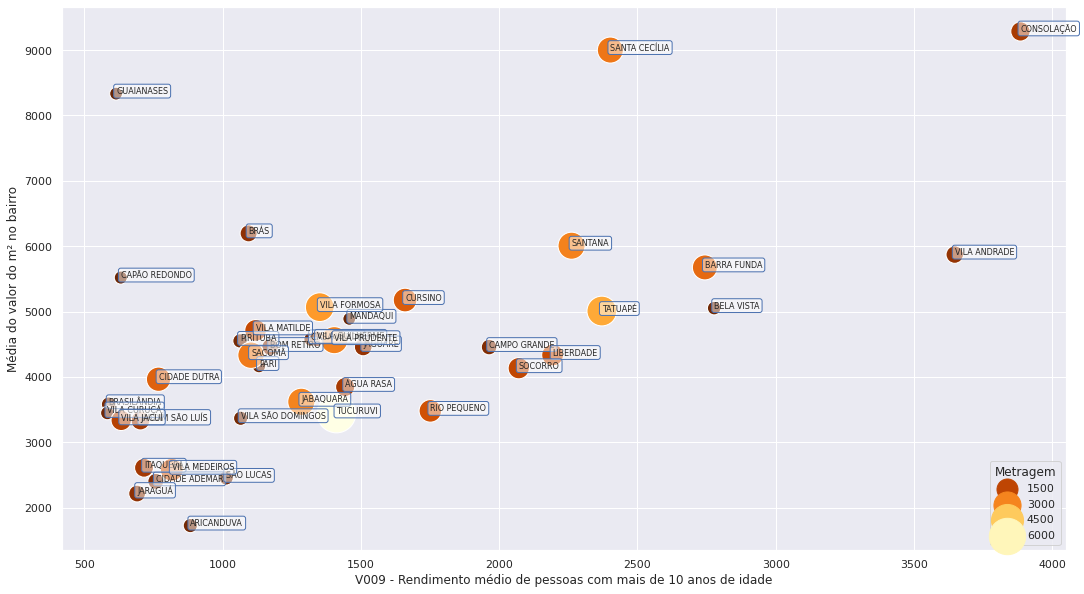

In [132]:
plot_data = district_IQR.groupby(['Bairro']).mean().reset_index()

plt.figure(figsize=(18, 10))
for i, b in enumerate(plot_data["Bairro"]):
  plt.annotate(b, (plot_data["V009"][i], plot_data["District_m2"][i]), bbox=dict(boxstyle="round", fc=(1,1,1, 0.5), ec="b"), size=8)

ax1 = sns.scatterplot(data=plot_data, x="V009", y="District_m2", hue="Metragem", size="Metragem", palette = "YlOrBr_r", sizes=(150, 1500))
ax1.set_xlabel("V009 - Rendimento médio de pessoas com mais de 10 anos de idade")
ax1.set_ylabel("Média do valor do m² no bairro")

Text(0.5, 0, 'Variância do rendimento mensal de pessoas de 10 anos ou mais')

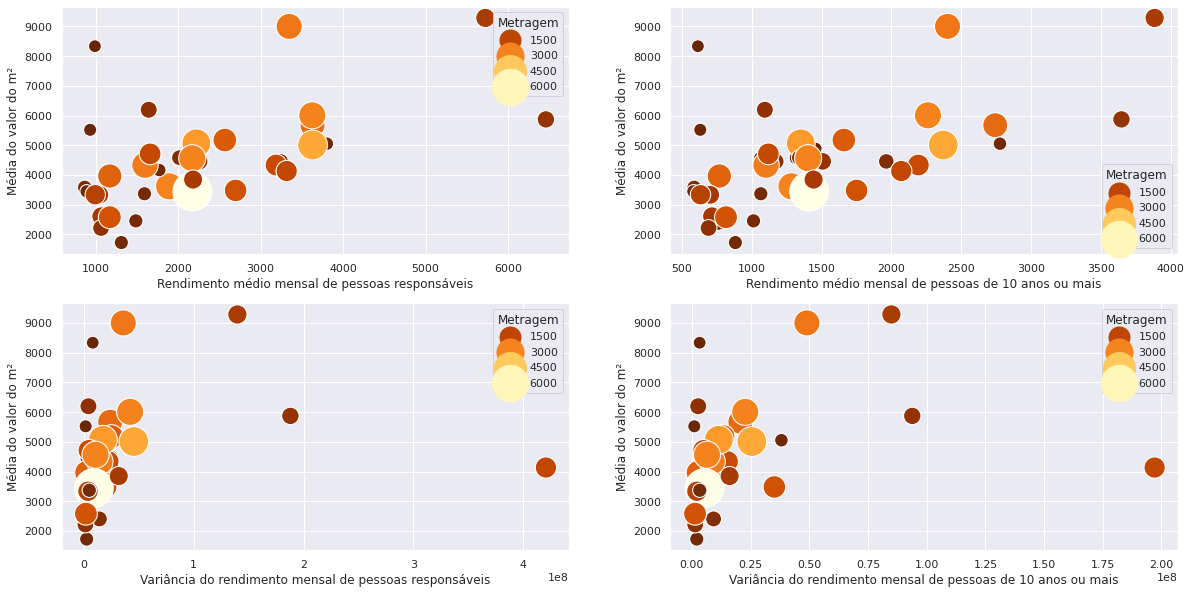

In [133]:
#some other correlations
f, axes = plt.subplots(2, 2)
sns.set(rc = {'figure.figsize':(16,12)})

ax05 = sns.scatterplot(data=plot_data, x=plot_data["V005"], y="District_m2", hue="Metragem",
                       size="Metragem", palette = "YlOrBr_r", sizes=(150, 1500), ax=axes[0,0])
ax06 = sns.scatterplot(data=plot_data, x=plot_data["V006"], y="District_m2", hue="Metragem",
                       size="Metragem", palette = "YlOrBr_r", sizes=(150, 1500), ax=axes[1,0])
ax09 = sns.scatterplot(data=plot_data, x=plot_data["V009"], y="District_m2", hue="Metragem",
                       size="Metragem", palette = "YlOrBr_r", sizes=(150, 1500), ax=axes[0,1])
ax10 = sns.scatterplot(data=plot_data, x=plot_data["V010"], y="District_m2", hue="Metragem",
                       size="Metragem", palette = "YlOrBr_r", sizes=(150, 1500), ax=axes[1,1])

ax05.set_ylabel("Média do valor do m²")
ax06.set_ylabel("Média do valor do m²")
ax09.set_ylabel("Média do valor do m²")
ax10.set_ylabel("Média do valor do m²")
ax05.set_xlabel("Rendimento médio mensal de pessoas responsáveis")
ax06.set_xlabel("Variância do rendimento mensal de pessoas responsáveis")
ax09.set_xlabel("Rendimento médio mensal de pessoas de 10 anos ou mais")
ax10.set_xlabel("Variância do rendimento mensal de pessoas de 10 anos ou mais")

Text(0.5, 1.0, 'V009 - Rendimento médio mensal de pessoas de 10 anos ou mais')

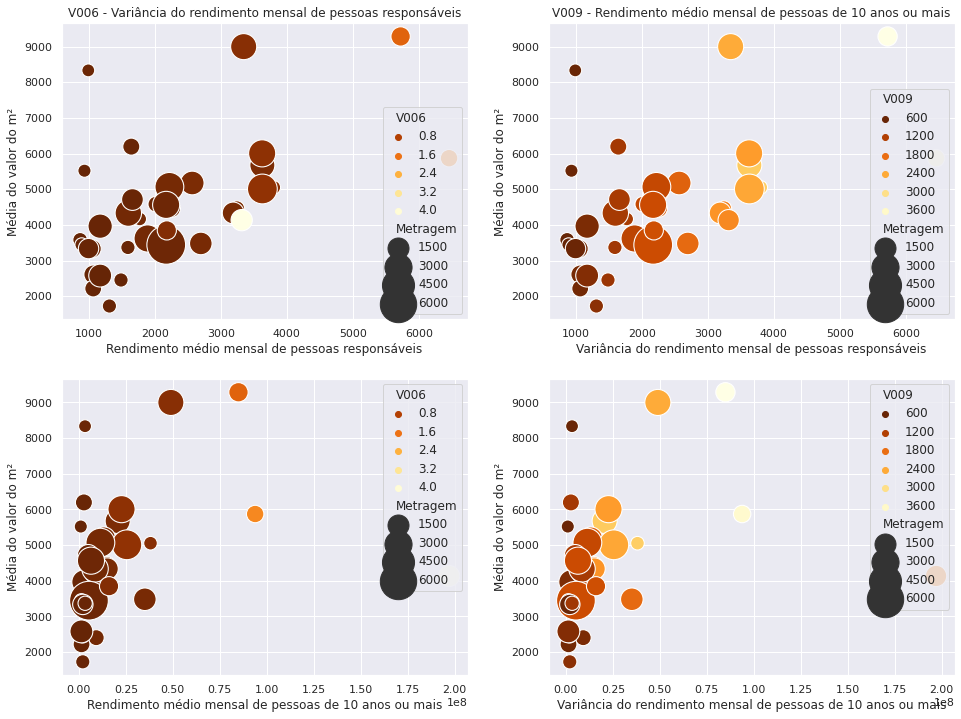

In [134]:
f, axes = plt.subplots(2, 2)
sns.set(rc = {'figure.figsize':(36,12)})

ax05_06 = sns.scatterplot(data=plot_data, x=plot_data["V005"], y="District_m2", hue="V006",
                          size="Metragem", palette = "YlOrBr_r", sizes=(150, 1500), ax=axes[0,0])
ax05_09 = sns.scatterplot(data=plot_data, x=plot_data["V005"], y="District_m2", hue="V009",
                          size="Metragem", palette = "YlOrBr_r", sizes=(150, 1500), ax=axes[0,1])
ax10_06 = sns.scatterplot(data=plot_data, x=plot_data["V010"], y="District_m2", hue="V006",
                          size="Metragem", palette = "YlOrBr_r", sizes=(150, 1500), ax=axes[1,0])
ax10_09 = sns.scatterplot(data=plot_data, x=plot_data["V010"], y="District_m2", hue="V009",
                          size="Metragem", palette = "YlOrBr_r", sizes=(150, 1500), ax=axes[1,1])

ax05_06.set_ylabel("Média do valor do m²")
ax05_09.set_ylabel("Média do valor do m²")
ax10_06.set_ylabel("Média do valor do m²")
ax10_09.set_ylabel("Média do valor do m²")

ax05_06.set_xlabel("Rendimento médio mensal de pessoas responsáveis")
ax05_09.set_xlabel("Variância do rendimento mensal de pessoas responsáveis")
ax10_06.set_xlabel("Rendimento médio mensal de pessoas de 10 anos ou mais")
ax10_09.set_xlabel("Variância do rendimento mensal de pessoas de 10 anos ou mais")

ax05_06.set_title("V006 - Variância do rendimento mensal de pessoas responsáveis")
ax05_09.set_title("V009 - Rendimento médio mensal de pessoas de 10 anos ou mais")
#ax10_06.set_title("V006 - Variância do rendimento mensal de pessoas responsáveis")
#ax10_09.set_title("V009 - Rendimento médio mensal de pessoas de 10 anos ou mais")

#Plotting Maps

In [ ]:
# creating a map
center = [-23.55, -46.63]
m_stamem = folium.Map(location=center, 
                 width=500,height=500,
                 tiles='Stamen Toner', zoom_start=12)
m_stamem

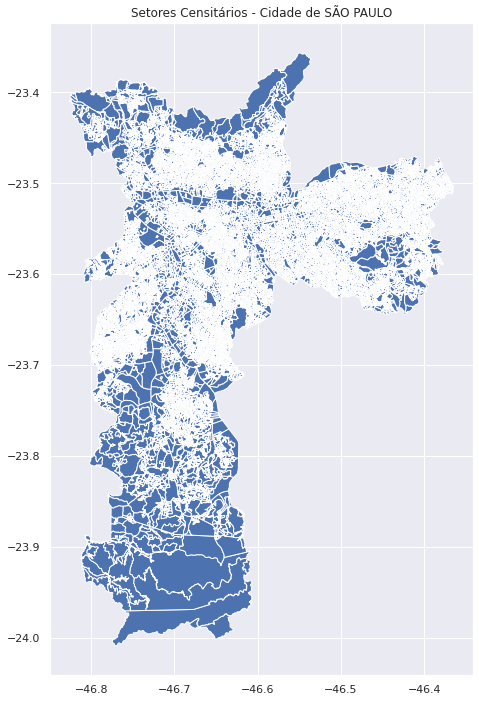

In [ ]:
#sp_gpkg = ibge_gpkg[ibge_gpkg.NM_MUNICIP == "SÃO PAULO"]
city_name = "SÃO PAULO"
city = ibge_gpkg[ibge_gpkg.NM_MUNICIP == city_name].reset_index(drop=True)
ax_city = city.plot(figsize=(8,12))
ax_city.set_title('Setores Censitários - Cidade de '+city_name);

#city_name = "VILA MARIANA"
#cidade_sao_paulo = sp[sp.NM_MUNICIP == 'SÃO PAULO'].reset_index(drop=True)
#ax2 = cidade_sao_paulo.plot(figsize=(40,25), column='V005', cmap='OrRd', edgecolor='gray', legend=True)
#ax2.set_title('Classificação Coroplética da Renda nos Setores Censitários - Cidade São Paulo');

In [ ]:
sp_ibge.Cod_setor = sp_ibge.Cod_setor.astype(str)
city_df = sp_gpkg.merge(sp_ibge, left_on='CD_GEOCODI', right_on='Cod_setor', how='left')
#print(f'type: {type(sp_df)}')
city_df.info()

In [ ]:
city_df['centroid'] = city_df['geometry'].apply(lambda z: (z.centroid.y, z.centroid.x))
# Add points to the map
mc = MarkerCluster()
for idx, row in city_df.iterrows():
    mc.add_child(Marker(row['centroid'], popup=row['NM_BAIRRO']))

m_stamem.add_child(mc)
# Display the map
m_stamem

Text(0.5, 1.0, 'Classificação Coroplética da Renda nos Setores Censitários - SÃO PAULO')

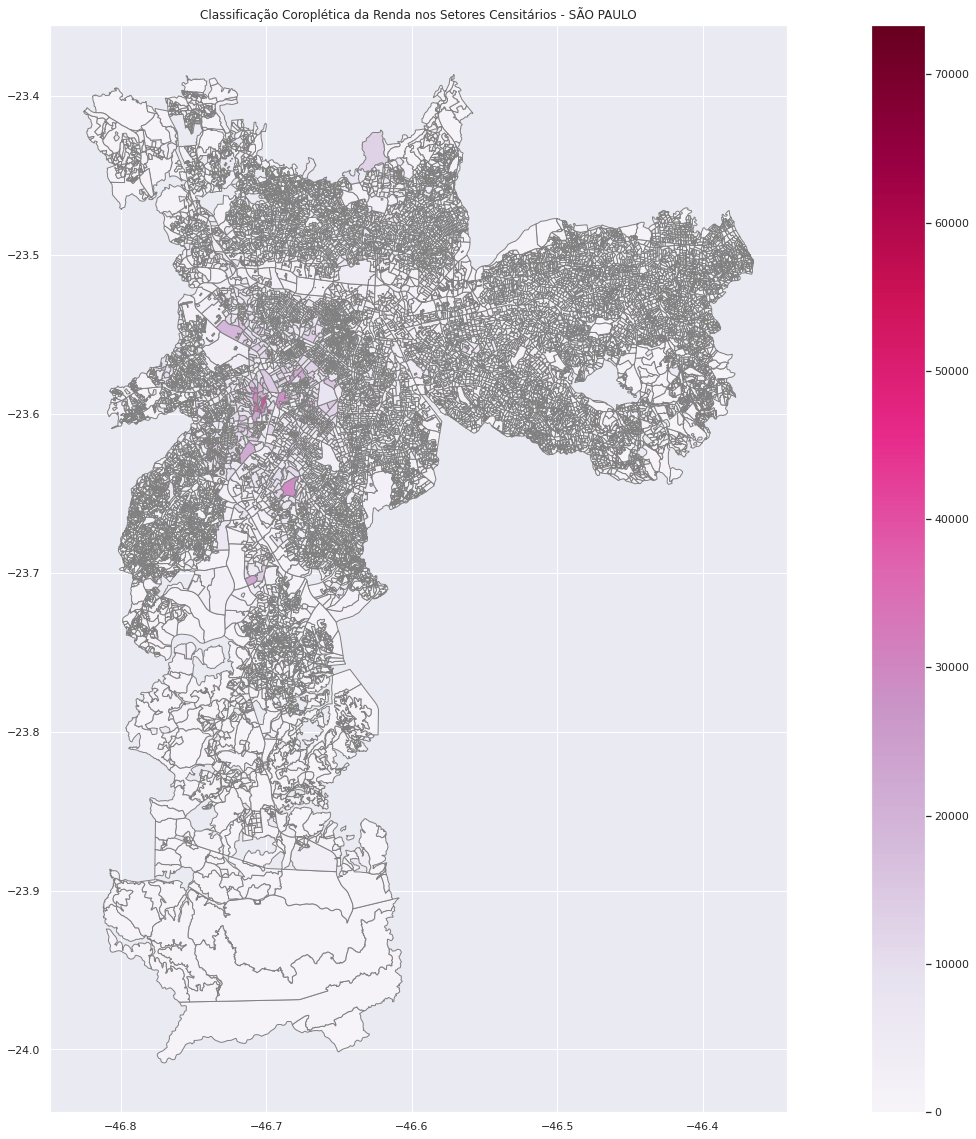

In [ ]:
#city
city_plot = city_df[city_df.NM_MUNICIP == city_name].reset_index(drop=True)
ax1 = city_plot.plot(figsize=(30,20), column='V005', cmap='PuRd', edgecolor='gray', legend=True)
ax1.set_title('Classificação Coroplética da Renda nos Setores Censitários - '+city_name)

Text(0.5, 1.0, 'Classificação Coroplética da Renda nos Setores Censitários - VILA MARIANA')

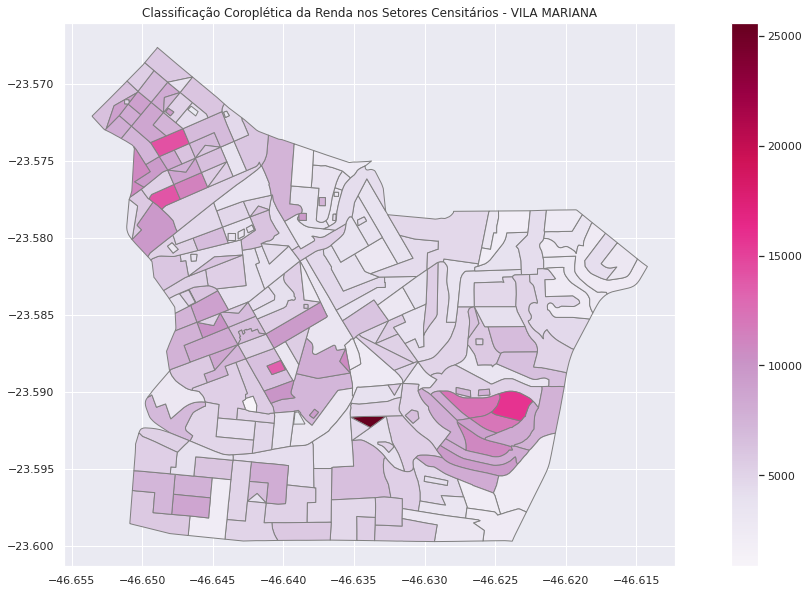

In [ ]:
#districts
district_name = "VILA MARIANA"
district_plot = city_df[city_df.NM_DISTRIT == district_name].reset_index(drop=True)
ax1 = district_plot.plot(figsize=(20,10), column='V005', cmap='PuRd', edgecolor='gray', legend=True)
ax1.set_title('Classificação Coroplética da Renda nos Setores Censitários - '+district_name)

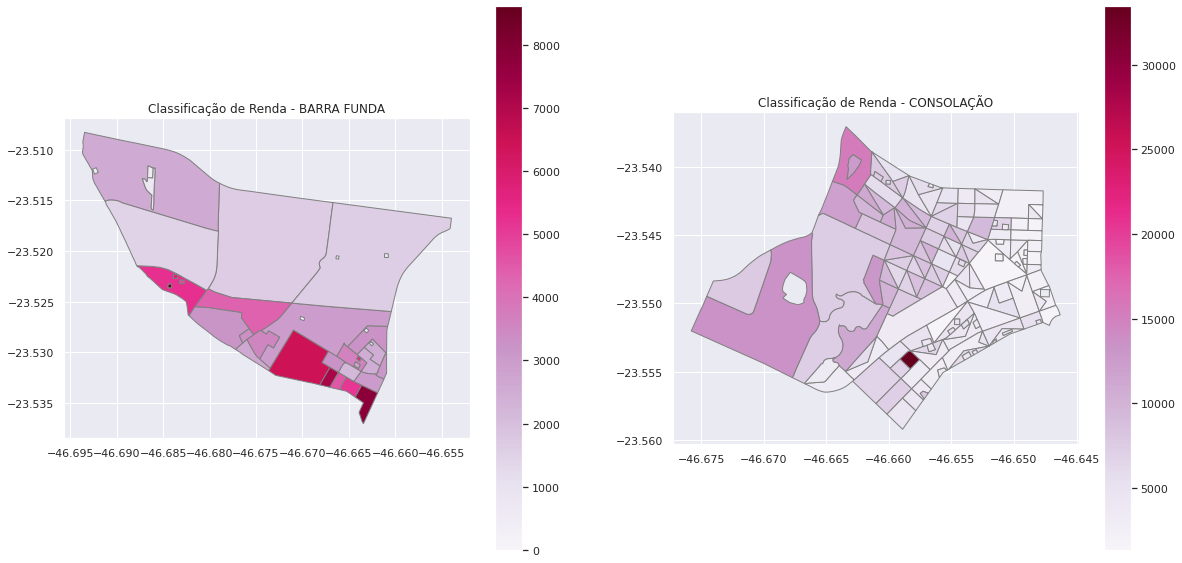

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
f, axes = plt.subplots(nrows=1, ncols=2)
d_list = ['BARRA FUNDA', 'CONSOLAÇÃO']

count = 0
for i in d_list:
  d_plot = city_df[city_df.NM_DISTRIT == i].reset_index(drop=True)
  ax = d_plot.plot(column='V005', cmap='PuRd', edgecolor='gray', ax=axes[count], legend = True)
  ax.set_title('Classificação de Renda - '+i)
  count+=1